In [2]:
import numpy as np
import matplotlib.pyplot as plt
from meer21cm.mock import MockSimulation
from multiprocessing import Pool
from func_00 import get_3d_power
from meer21cm.power import bin_3d_to_1d, bin_3d_to_cy
from meer21cm.grid import project_particle_to_regular_grid


/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


In [3]:
mock = MockSimulation(
    band='L',
    survey='meerklass_2021',
    kaiser_rsd=True,
    tracer_bias_2=1.0,
    num_discrete_source=1e6,
)
mock._box_len = np.array([1000,1000,1000])
mock._box_ndim = np.array([50,50,50])
mock.propagate_field_k_to_model()

Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False


/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/numpy/fft/_helper.py:170: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/numpy/fft/_helper.py:177: RuntimeWarning: invalid value encountered in multiply
  return results * val


In [9]:
mock.k_perp.max(),mock.k_para.max()

(np.float64(0.2221441469079183), np.float64(0.15079644737231007))

In [4]:
mock.k1dbins = np.geomspace(0.005,0.27,11)
mock.kperpbins = np.linspace(0,0.22,23)
mock.kparabins = np.linspace(0,0.15,16)

In [ ]:
pdata3d_arr = []
pmod3d_arr = []
pg3d_arr = []
with Pool(10) as p:
    for pdata3d,pmod3d,pg3d in p.map(get_3d_power,range(100)):
        pdata3d_arr.append(pdata3d)
        pmod3d_arr.append(pmod3d)
        pg3d_arr.append(pg3d)
pdata3d_arr = np.array(pdata3d_arr)
pmod3d_arr = np.array(pmod3d_arr)
pg3d_arr = np.array(pg3d_arr)

In [6]:
pdatacy_arr = bin_3d_to_cy(pdata3d_arr, mock.k_perp, mock.kperpbins, vectorize=True)
pdatacy_arr = bin_3d_to_cy(pdatacy_arr, np.abs(mock.k_para), mock.kparabins, vectorize=True)
pmodcy_arr = bin_3d_to_cy(pmod3d_arr, mock.k_perp, mock.kperpbins, vectorize=True)
pmodcy_arr = bin_3d_to_cy(pmodcy_arr, np.abs(mock.k_para), mock.kparabins, vectorize=True)
pgcy_arr = bin_3d_to_cy(pg3d_arr, mock.k_perp, mock.kperpbins, vectorize=True)
pgcy_arr = bin_3d_to_cy(pgcy_arr, np.abs(mock.k_para), mock.kparabins, vectorize=True)


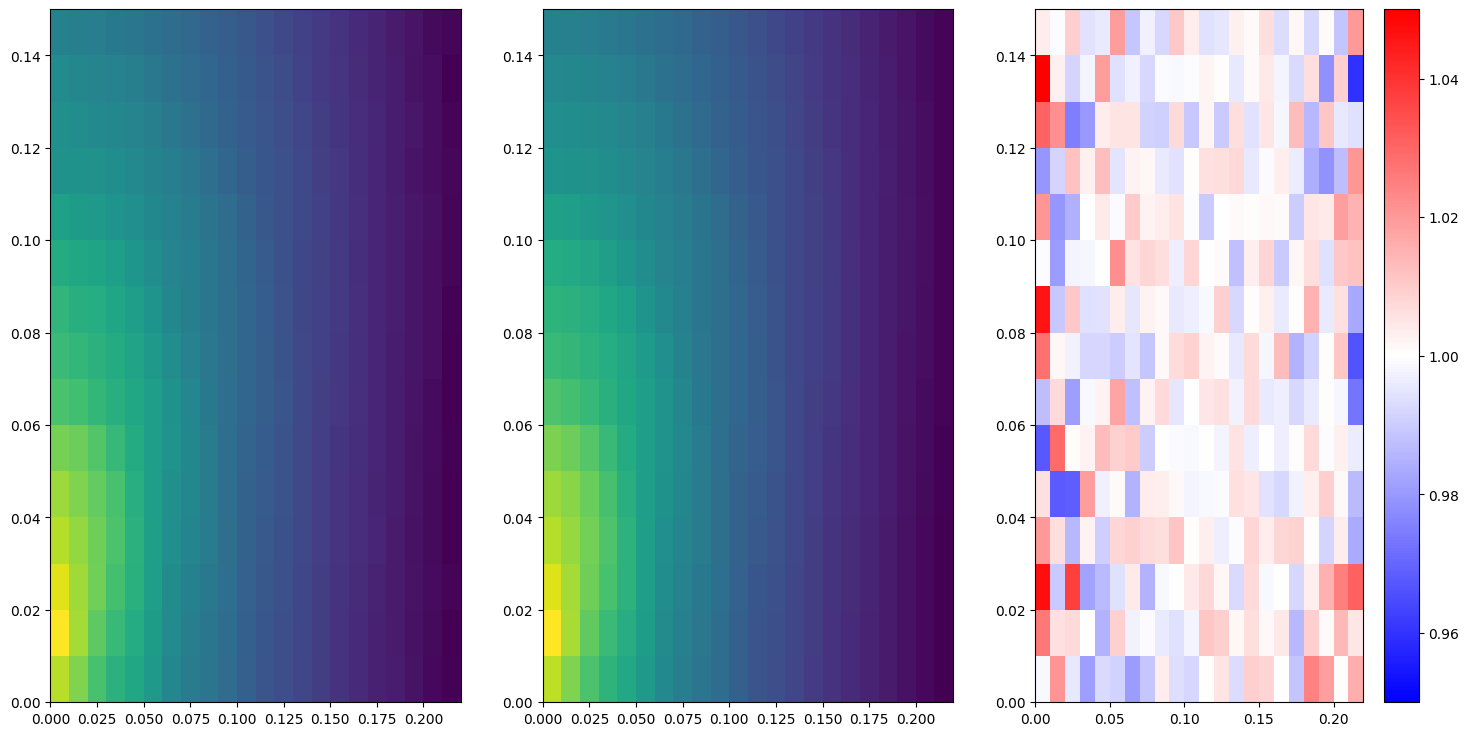

In [8]:
fig,axes = plt.subplots(1,3)
axes[0].pcolormesh(mock.kperpbins,mock.kparabins,np.log10(pdatacy_arr.mean(axis=0).T))
axes[1].pcolormesh(mock.kperpbins,mock.kparabins,np.log10(pmodcy_arr.mean(axis=0).T))
im = axes[2].pcolormesh(
    mock.kperpbins,mock.kparabins,(pdatacy_arr.mean(axis=0).T)/(pmodcy_arr.mean(axis=0).T),
    vmin=0.95, vmax=1.05, cmap='bwr',
)
plt.colorbar(im)

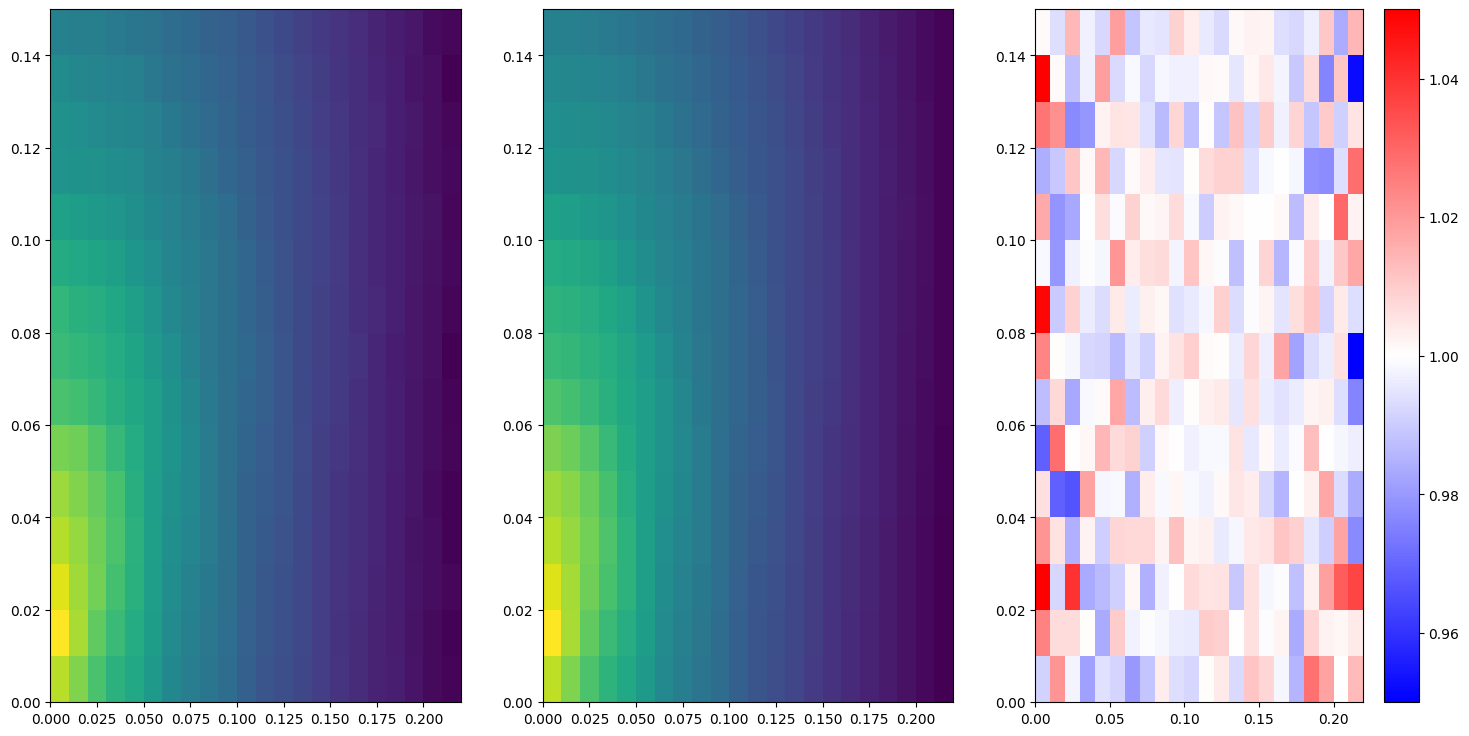

In [9]:
fig,axes = plt.subplots(1,3)
axes[0].pcolormesh(mock.kperpbins,mock.kparabins,np.log10(pgcy_arr.mean(axis=0).T))
axes[1].pcolormesh(mock.kperpbins,mock.kparabins,np.log10(pmodcy_arr.mean(axis=0).T))
im = axes[2].pcolormesh(
    mock.kperpbins,mock.kparabins,(pgcy_arr.mean(axis=0).T)/(pmodcy_arr.mean(axis=0).T),
    vmin=0.95, vmax=1.05, cmap='bwr',
)
plt.colorbar(im)

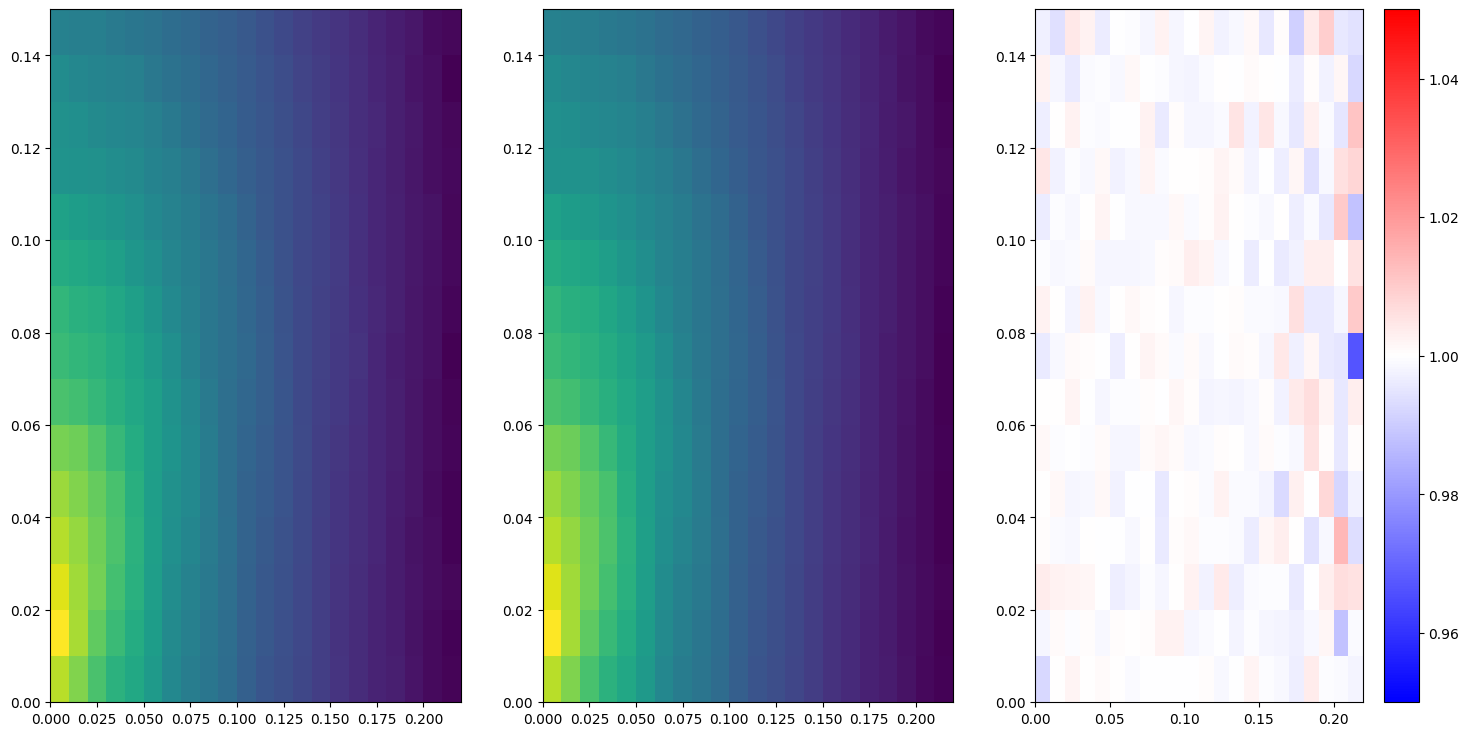

In [10]:
fig,axes = plt.subplots(1,3)
axes[0].pcolormesh(mock.kperpbins,mock.kparabins,np.log10(pgcy_arr.mean(axis=0).T))
axes[1].pcolormesh(mock.kperpbins,mock.kparabins,np.log10(pdatacy_arr.mean(axis=0).T))
im = axes[2].pcolormesh(
    mock.kperpbins,mock.kparabins,(pgcy_arr.mean(axis=0).T)/(pdatacy_arr.mean(axis=0).T),
    vmin=0.95, vmax=1.05, cmap='bwr',
)
plt.colorbar(im)

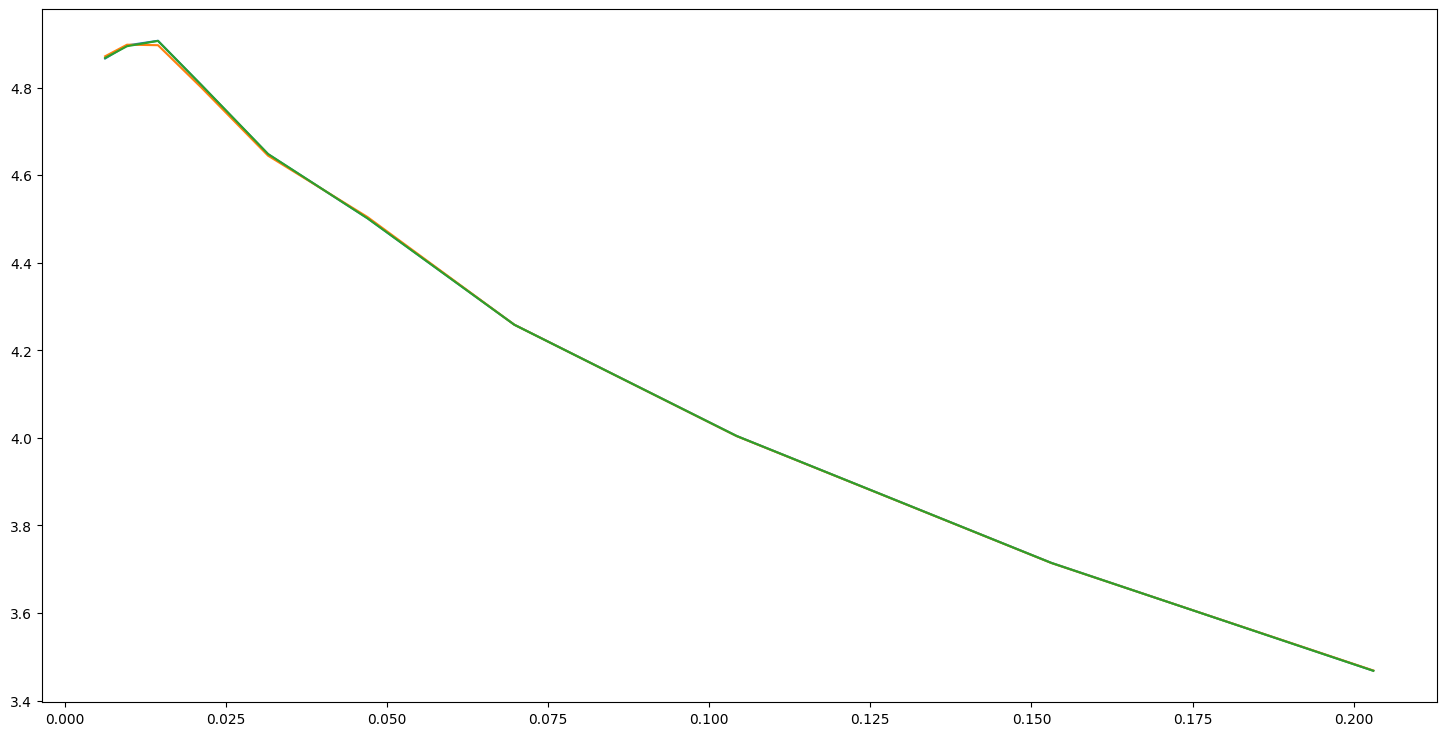

In [13]:
pdata1d_arr,keff,nmodes = bin_3d_to_1d(pdata3d_arr, mock.kmode, mock.k1dbins, vectorize=True)
pmod1d_arr,keff,nmodes = bin_3d_to_1d(pmod3d_arr, mock.kmode, mock.k1dbins, vectorize=True)
pg1d_arr,keff,nmodes = bin_3d_to_1d(pg3d_arr, mock.kmode, mock.k1dbins, vectorize=True)
plt.plot(keff,np.log10(pdata1d_arr.mean(axis=0)))
plt.plot(keff,np.log10(pmod1d_arr.mean(axis=0)))
plt.plot(keff,np.log10(pg1d_arr.mean(axis=0)))


In [14]:
# save some data for later production
np.save('data/pdata1d_arr_00.npy',pdata1d_arr)
np.save('data/pmod1d_arr_00.npy',pmod1d_arr)
np.save('data/pg1d_arr_00.npy',pg1d_arr)
np.save('data/keff_00.npy',keff)
np.save('data/nmodes_00.npy',nmodes)
np.save('data/pdatacy_arr_00.npy',pdatacy_arr)
np.save('data/pmodcy_arr_00.npy',pmodcy_arr)
np.save('data/pgcy_arr_00.npy',pgcy_arr)






